In [1]:
import sys
sys.path.insert(1,'../../../SUSAN') # Path to SUSAN

In [2]:
# SUSAN requires NUMPY and NUMBA
import susan
import numpy as np
import matplotlib.pyplot as plt

# For visualization
import napari

# To create masks:
from scipy.ndimage import gaussian_filter as gauss
from scipy.ndimage import binary_dilation as dilat

In [3]:
# %% Create Tomostxt:
N = 4
K = 61

tomos = susan.data.Tomograms(n_tomo=N,n_proj=K)
apix  = 2.62
tsiz  = (3710,3710,880)
for i in range(4):
    base = 'data/mixedCTEM_tomo%d' % (i+1)
    tomos.tomo_id[i] = i+1
    tomos.set_stack  (i,base+'.b1.ali.mrc')
    tomos.set_angles (i,base+'.tlt')
    tomos.set_defocus(i,base+'.defocus')
    tomos.pix_size[i]  = apix
    tomos.tomo_size[i] = tsiz
tomos.save('tomos_b1.tomostxt')

tomos = susan.data.Tomograms(n_tomo=N,n_proj=K)
apix  = 2.62*2
tsiz  = (3710/2,3710/2,880/2)
for i in range(4):
    base = 'data/mixedCTEM_tomo%d' % (i+1)
    tomos.tomo_id[i] = i+1
    tomos.set_stack  (i,base+'.b2.ali.mrc')
    tomos.set_angles (i,base+'.tlt')
    tomos.set_defocus(i,base+'.defocus')
    tomos.pix_size[i]  = apix
    tomos.tomo_size[i] = tsiz
tomos.save('tomos_b2.tomostxt')

tomos = susan.data.Tomograms(n_tomo=N,n_proj=K)
apix  = 2.62*4
tsiz  = (3710/4,3710/4,880/4)
for i in range(4):
    base = 'data/mixedCTEM_tomo%d' % (i+1)
    tomos.tomo_id[i] = i+1
    tomos.set_stack  (i,base+'.b4.ali.mrc')
    tomos.set_angles (i,base+'.tlt')
    tomos.set_defocus(i,base+'.defocus')
    tomos.pix_size[i]  = apix
    tomos.tomo_size[i] = tsiz
tomos.save('tomos_b4.tomostxt')

tomos = susan.data.Tomograms(n_tomo=N,n_proj=K)
apix  = 2.62*8
tsiz  = (3710/8,3710/8,880/8)
for i in range(4):
    base = 'data/mixedCTEM_tomo%d' % (i+1)
    tomos.tomo_id[i] = i+1
    tomos.set_stack  (i,base+'.b8.ali.mrc')
    tomos.set_angles (i,base+'.tlt')
    tomos.set_defocus(i,base+'.defocus')
    tomos.pix_size[i]  = apix
    tomos.tomo_size[i] = tsiz
tomos.save('tomos_b8.tomostxt')

In [4]:
# Load DYNAMO table with NUMPY and convert it to PTCLSRAW
tbl_B8 = np.loadtxt('picked_b8.tbl',unpack=True)
tomoB8 = susan.read('tomos_b8.tomostxt')
ptcls  = susan.data.Particles.import_data(tomograms=tomoB8,
                                          position=tbl_B8[23:26,:].transpose(),
                                          ptcls_id=tbl_B8[0],
                                          tomos_id=tbl_B8[19])
ptcls.save('prj_001.ptclsraw')

    Volume reconstruction. Box size: 32
    - Input files: prj_001.ptclsraw | tomos_b8.tomostxt
    - Output prefix: prj_001
    - 1 GPU (GPU id: 0), and 1 thread.
    - Bandpass: [0.0 - 15.0]  (roll off: 2.00).
    - Wiener Inversion. Normalized to Mean=0, Std=1.
    - c1 Symmetry. Inversion: Ite=10 Std=0.750000
	Loading data files... Done
    - 4427 Particles (1 classes) in 4 tomograms with max 61 projections.
        Filling fourier space: 100.00%                           
        Reconstructing prj_001_class001.mrc ...  Done.


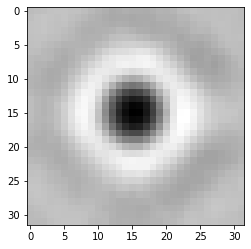

In [5]:
avgr = susan.modules.Averager()
avgr.list_gpus_ids  = [0]
avgr.ctf_correction = 'wiener'
avgr.rec_halfsets   = False
avgr.reconstruct('prj_001','tomos_b8.tomostxt','prj_001.ptclsraw',32)
# Initial reconstruction should looks like a sphere (no angles)
v,_ = susan.io.mrc.read('prj_001_class001.mrc')
plt.imshow(v[16],'gray')

In [6]:
# Duplicate reference to run a MRA project
ptcls = susan.data.Particles('prj_001.ptclsraw')
susan.data.Particles.MRA.duplicate(ptcls,0)
ptcls.save('prj_001_mra.ptclsraw')

In [7]:
susan.io.mrc.write(-susan.utils.create_sphere( 4,64),   'gb_b4.mrc'   ,2.62*4)
susan.io.mrc.write( susan.utils.create_sphere(24,64),'mask_sph_b4.mrc',2.62*4)
refs = susan.data.Reference(n_refs=2)
refs.ref[0] = 'emd_3420_b4.mrc'
refs.msk[0] = 'mask_sph_b4.mrc'
refs.ref[1] = 'gb_b4.mrc'
refs.msk[1] = 'mask_sph_b4.mrc'
refs.save('prj_001_b4.refstxt')

In [8]:
mngr = susan.project.Manager('prj_001_b4',64)

mngr.initial_reference = 'prj_001_b4.refstxt'
mngr.initial_particles = 'prj_001_mra.ptclsraw'
mngr.tomogram_file     = 'tomos_b4.tomostxt'
mngr.list_gpus_ids     = [0,1,2,3] # List of GPUs ID to use
mngr.aligner.ctf_correction  = 'cfsc'
mngr.aligner.allow_drift     = True
mngr.averager.ctf_correction = 'phase_flip'
mngr.cc_threshold   = 0.9
mngr.iteration_type = 3 # 3D Alignment

In [9]:
mngr.aligner.bandpass.highpass = 0
mngr.aligner.bandpass.lowpass  = 21

mngr.aligner.set_angular_search(360,30,360,30)
mngr.aligner.refine.levels = 2
mngr.aligner.refine.factor = 1
mngr.aligner.set_offset_search(20,1)

bp = mngr.execute_iteration(1)

Project: prj_001_b4 (Iteration 1)
  [3D Alignment] Start:
  Volume 3D alignment. Box size: 64
    - Input files: tomos_b4.tomostxt | prj_001_b4.refstxt
    - Particles In/Out: prj_001_mra.ptclsraw | prj_001_b4/ite_0001/particles.ptclsraw
    - 4 GPUs (GPU ids: 0,1,2,3), and 4 threads.
    - Bandpass: [0.0 - 21.0]  (roll off: 2.00).
    - On Substack (CFSC). Normalized to Mean=0, Std=1.
    - Angular search: Sym=c1 | Cone=360.000,30.000 | Inplace=360.000,30.000 | Refinement: 2|1.
    - Angles | 552 | 21 | 21 [594].
    - Ellipsoid offset (3D): [20.00,20.00,20.00], Step=1.00. Points: 33401
    - 4427 Particles (2 classes) in 4 tomograms with max 61 projections.
        Aligning particles: 100.00%                              
  [3D Alignment] Finished. Elapsed time: 332.5 seconds (0:05:32.509556).
  [Aligned partices] Processing:
    Class  1:    4231 particles [   3807].
      Half 1:    2123 particles [   1910].
      Half 2:    2108 particles [   1897].
    Class  2:     196 particles

In [10]:
mngr.aligner.bandpass.highpass = 0
mngr.aligner.bandpass.lowpass  = 21

mngr.aligner.set_angular_search(0,1,0,1)
mngr.aligner.refine.levels = 0
mngr.aligner.refine.factor = 1
mngr.aligner.set_offset_search(12,1)

bp = mngr.execute_iteration(2)

Project: prj_001_b4 (Iteration 2)
  [3D Alignment] Start:
  Volume 3D alignment. Box size: 64
    - Input files: tomos_b4.tomostxt | prj_001_b4/ite_0001/reference.refstxt
    - Particles In/Out: prj_001_b4/ite_0001/particles.ptclsraw | prj_001_b4/ite_0002/particles.ptclsraw
    - 4 GPUs (GPU ids: 0,1,2,3), and 4 threads.
    - Bandpass: [0.0 - 21.0]  (roll off: 2.00).
    - On Substack (CFSC). Normalized to Mean=0, Std=1.
    - Angular search: Sym=c1 | Cone=0.000,1.000 | Inplace=0.000,1.000 | Refinement: 0|1.
    - Angles | 1 [1].
    - Ellipsoid offset (3D): [12.00,12.00,12.00], Step=1.00. Points: 7153
    - 4427 Particles (2 classes) in 4 tomograms with max 61 projections.
        Aligning particles: 100.00%                              
  [3D Alignment] Finished. Elapsed time: 6.0 seconds (0:00:06.023605).
  [Aligned partices] Processing:
    Class  1:    2799 particles [   2518].
      Half 1:    1394 particles [   1254].
      Half 2:    1405 particles [   1264].
    Class  2:    

In [11]:
mngr.aligner.bandpass.highpass = 0
mngr.aligner.bandpass.lowpass  = 21

mngr.aligner.set_angular_search(32,6,32,6)
mngr.aligner.refine.levels = 2
mngr.aligner.refine.factor = 1
mngr.aligner.set_offset_search(18,1)

for i in range(3,6):
    _ = mngr.execute_iteration(i)

Project: prj_001_b4 (Iteration 3)
  [3D Alignment] Start:
  Volume 3D alignment. Box size: 64
    - Input files: tomos_b4.tomostxt | prj_001_b4/ite_0002/reference.refstxt
    - Particles In/Out: prj_001_b4/ite_0002/particles.ptclsraw | prj_001_b4/ite_0003/particles.ptclsraw
    - 4 GPUs (GPU ids: 0,1,2,3), and 4 threads.
    - Bandpass: [0.0 - 21.0]  (roll off: 2.00).
    - On Substack (CFSC). Normalized to Mean=0, Std=1.
    - Angular search: Sym=c1 | Cone=32.000,6.000 | Inplace=32.000,6.000 | Refinement: 2|1.
    - Angles | 95 | 21 | 21 [137].
    - Ellipsoid offset (3D): [18.00,18.00,18.00], Step=1.00. Points: 24405
    - 4427 Particles (2 classes) in 4 tomograms with max 61 projections.
        Aligning particles: 100.00%                              
  [3D Alignment] Finished. Elapsed time: 70.7 seconds (0:01:10.743956).
  [Aligned partices] Processing:
    Class  1:    3299 particles [   2969].
      Half 1:    1640 particles [   1476].
      Half 2:    1659 particles [   1493].


In [15]:
# Show class 1 (Ribosome)
_ = napari.view_image(-mngr.get_map(5,1))
# Show class 2 (Goldbead)
_ = napari.view_image(-mngr.get_map(5,2))

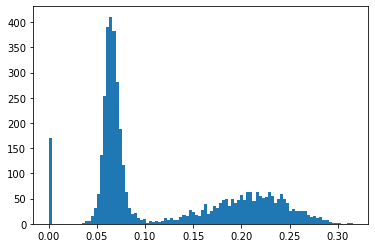

In [13]:
plt.figure()
_ = plt.hist( mngr.get_cc(5,1), 100 )
_ = plt.hist( mngr.get_cc(5,2), 100 )

In [15]:
# Continue processing only with first class
p0 = mngr.get_ptcls(5)
p1 = susan.data.Particles.MRA.select_ref(p0,0)
p2 = p1.select(p1.ali_cc[0]>0.02)
p2.save('prj_002.ptclsraw')

In [16]:
avgr = susan.modules.Averager()
avgr.list_gpus_ids  = [0]
avgr.ctf_correction = 'wiener'
avgr.rec_halfsets   = False
avgr.reconstruct('prj_002','tomos_b2.tomostxt','prj_002.ptclsraw',128)

    Volume reconstruction. Box size: 128
    - Input files: prj_002.ptclsraw | tomos_b2.tomostxt
    - Output prefix: prj_002
    - 1 GPU (GPU id: 0), and 1 thread.
    - Bandpass: [0.0 - 63.0]  (roll off: 2.00).
    - Wiener Inversion. Normalized to Mean=0, Std=1.
    - c1 Symmetry. Inversion: Ite=10 Std=0.750000
	Loading data files... Done
    - 3461 Particles (1 classes) in 4 tomograms with max 61 projections.
        Filling fourier space: 100.00%                           
        Reconstructing prj_002_class001.mrc ...  Done.


In [17]:
a = susan.utils.bandpass(susan.read('prj_002_class001.mrc'),lowpass=20) # lowpass in fourier pixels
t = np.quantile(a.flatten(),0.1)
b = (a<t)*(susan.utils.create_sphere(38,128)>0.5)
b = dilat(b,structure=susan.utils.create_sphere(3,8))
c = gauss(np.float32(b),1.5)
susan.io.mrc.write(c,'mask_b2_01.mrc')

refs = susan.data.Reference(n_refs=1)
refs.ref[0] = 'prj_002_class001.mrc'
refs.msk[0] = 'mask_b2_01.mrc'
refs.save('prj_002.refstxt')

In [18]:
mngr = susan.project.Manager('prj_002_b2',128)

mngr.initial_reference = 'prj_002.refstxt'
mngr.initial_particles = 'prj_002.ptclsraw'
mngr.tomogram_file     = 'tomos_b2.tomostxt'
mngr.list_gpus_ids     = [0,1,2,3]
mngr.aligner.ctf_correction  = 'cfsc'
mngr.aligner.allow_drift     = True
mngr.averager.ctf_correction = 'wiener'
mngr.cc_threshold   = 0.9
mngr.iteration_type = 3 # 3D Alignment

In [19]:
mngr.aligner.bandpass.highpass = 0

mngr.aligner.refine.factor = 2
mngr.aligner.set_offset_search(6,1)

# close-loop iterations
lp = 30
for i in range(1,11):
    ang_stp = np.rad2deg(np.arctan2(1,lp))
    mngr.aligner.bandpass.lowpass = lp
    if i == 1:
        mngr.aligner.set_angular_search(0,1,0,1)
        mngr.aligner.refine.levels = 0
    else:
        mngr.aligner.set_angular_search(4*ang_stp,ang_stp,4*ang_stp,ang_stp)
        mngr.aligner.refine.levels = 1
    # mngr.execute_iteration returns the estimated resolution, in fourier pixels,
    # using mngr.fsc_threshold as threshold (default: 0.143)
    bp = mngr.execute_iteration(i)
    if i == 1:
        lp = bp
    else:
        # Enforce a gradual increase in the lowpass
        lp = min(lp+2,bp)

Project: prj_002_b2 (Iteration 1)
  [3D Alignment] Start:
  Volume 3D alignment. Box size: 128
    - Input files: tomos_b2.tomostxt | prj_002.refstxt
    - Particles In/Out: prj_002.ptclsraw | prj_002_b2/ite_0001/particles.ptclsraw
    - 4 GPUs (GPU ids: 0,1,2,3), and 4 threads.
    - Bandpass: [0.0 - 30.0]  (roll off: 2.00).
    - On Substack (CFSC). Normalized to Mean=0, Std=1.
    - Angular search: Sym=c1 | Cone=0.000,1.000 | Inplace=0.000,1.000 | Refinement: 0|2.
    - Angles | 1 [1].
    - Ellipsoid offset (3D): [6.00,6.00,6.00], Step=1.00. Points: 925
    - 3461 Particles (1 classes) in 4 tomograms with max 61 projections.
        Aligning particles: 100.00%                              
  [3D Alignment] Finished. Elapsed time: 6.5 seconds (0:00:06.536336).
  [Aligned partices] Processing:
    Class  1:    3461 particles [   3114].
      Half 1:    1744 particles [   1569].
      Half 2:    1717 particles [   1545].
  [Aligned partices] Done.
  [Reconstruct Maps] Start:
    Volum

  Volume 3D alignment. Box size: 128
    - Input files: tomos_b2.tomostxt | prj_002_b2/ite_0004/reference.refstxt
    - Particles In/Out: prj_002_b2/ite_0004/particles.ptclsraw | prj_002_b2/ite_0005/particles.ptclsraw
    - 4 GPUs (GPU ids: 0,1,2,3), and 4 threads.
    - Bandpass: [0.0 - 50.0]  (roll off: 2.00).
    - On Substack (CFSC). Normalized to Mean=0, Std=1.
    - Angular search: Sym=c1 | Cone=4.583,1.146 | Inplace=4.583,1.146 | Refinement: 1|2.
    - Angles | 35 | 80 [115].
    - Ellipsoid offset (3D): [6.00,6.00,6.00], Step=1.00. Points: 925
    - 3461 Particles (1 classes) in 4 tomograms with max 61 projections.
        Aligning particles: 100.00%                              
  [3D Alignment] Finished. Elapsed time: 43.9 seconds (0:00:43.861179).
  [Aligned partices] Processing:
    Class  1:    3461 particles [   3114].
      Half 1:    1744 particles [   1569].
      Half 2:    1717 particles [   1545].
  [Aligned partices] Done.
  [Reconstruct Maps] Start:
    Volume rec

  Volume 3D alignment. Box size: 128
    - Input files: tomos_b2.tomostxt | prj_002_b2/ite_0008/reference.refstxt
    - Particles In/Out: prj_002_b2/ite_0008/particles.ptclsraw | prj_002_b2/ite_0009/particles.ptclsraw
    - 4 GPUs (GPU ids: 0,1,2,3), and 4 threads.
    - Bandpass: [0.0 - 58.0]  (roll off: 2.00).
    - On Substack (CFSC). Normalized to Mean=0, Std=1.
    - Angular search: Sym=c1 | Cone=3.951,0.988 | Inplace=3.951,0.988 | Refinement: 1|2.
    - Angles | 100 | 100 [200].
    - Ellipsoid offset (3D): [6.00,6.00,6.00], Step=1.00. Points: 925
    - 3461 Particles (1 classes) in 4 tomograms with max 61 projections.
        Aligning particles: 100.00%                              
  [3D Alignment] Finished. Elapsed time: 73.4 seconds (0:01:13.392097).
  [Aligned partices] Processing:
    Class  1:    3461 particles [   3114].
      Half 1:    1744 particles [   1569].
      Half 2:    1717 particles [   1545].
  [Aligned partices] Done.
  [Reconstruct Maps] Start:
    Volume r

    Volume reconstruction. Box size: 128
    - Input files: prj_003.ptclsraw | tomos_b2.tomostxt
    - Output prefix: prj_003
    - 4 GPUs (GPU ids: 0,1,2,3), and 4 threads.
    - Bandpass: [0.0 - 63.0]  (roll off: 2.00).
    - Wiener Inversion. Normalized to Mean=0, Std=1.
    - c1 Symmetry. Inversion: Ite=10 Std=0.750000
	Loading data files... Done
    - 3461 Particles (2 classes) in 4 tomograms with max 61 projections.
        Filling fourier space: 100.00%                           
        Reconstructing prj_003_class001.mrc ...  Done.
        Reconstructing prj_003_class002.mrc ...  Done.


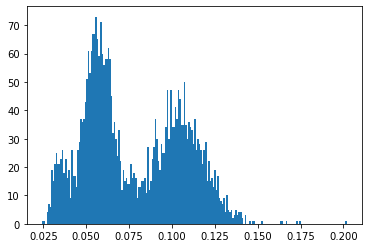

In [23]:
p1 = mngr.get_ptcls(10)
_ = plt.hist(p1.ali_cc[0],200)
susan.data.Particles.MRA.duplicate(p1,0)
p1.ref_cix[:] = p1.ali_cc[0]<0.05
p1.save('prj_003.ptclsraw')

avgr = susan.modules.Averager()
avgr.list_gpus_ids  = [0,1,2,3]
avgr.ctf_correction = 'wiener'
avgr.rec_halfsets   = False
avgr.reconstruct('prj_003','tomos_b2.tomostxt','prj_003.ptclsraw',128)

a = gauss(np.float32(susan.utils.create_sphere(39,128)),2)
susan.io.mrc.write(a,'mask_b2_02.mrc')

refs = susan.data.Reference(n_refs=2)
refs.ref[0] = 'prj_003_class001.mrc'
refs.msk[0] = 'mask_b2_02.mrc'
refs.ref[1] = 'prj_003_class002.mrc'
refs.msk[1] = 'mask_b2_02.mrc'
refs.save('prj_003.refstxt')

In [25]:
mngr = susan.project.Manager('prj_003_b2',128)

mngr.initial_reference = 'prj_003.refstxt'
mngr.initial_particles = 'prj_003.ptclsraw'
mngr.tomogram_file     = 'tomos_b2.tomostxt'
mngr.list_gpus_ids     = [0,1,2,3]
mngr.aligner.ctf_correction  = 'cfsc'
mngr.aligner.allow_drift     = True
mngr.averager.ctf_correction = 'wiener'
mngr.cc_threshold   = 0.4
mngr.iteration_type = 3 # 3D Alignment

In [26]:
mngr.aligner.bandpass.highpass = 0
mngr.aligner.bandpass.rolloff  = 15
mngr.aligner.bandpass.lowpass  = 30
mngr.aligner.set_angular_search(8,2,8,2)
mngr.aligner.refine.levels = 0
mngr.aligner.refine.factor = 1
mngr.aligner.set_offset_search(5,1)

for i in range(1,6):
    _ = mngr.execute_iteration(i)

Project: prj_003_b2 (Iteration 1)
  [3D Alignment] Start:
  Volume 3D alignment. Box size: 128
    - Input files: tomos_b2.tomostxt | prj_003.refstxt
    - Particles In/Out: prj_003.ptclsraw | prj_003_b2/ite_0001/particles.ptclsraw
    - 4 GPUs (GPU ids: 0,1,2,3), and 4 threads.
    - Bandpass: [0.0 - 30.0]  (roll off: 15.00).
    - On Substack (CFSC). Normalized to Mean=0, Std=1.
    - Angular search: Sym=c1 | Cone=8.000,2.000 | Inplace=8.000,2.000 | Refinement: 0|1.
    - Angles | 100 [100].
    - Ellipsoid offset (3D): [5.00,5.00,5.00], Step=1.00. Points: 515
    - 3461 Particles (2 classes) in 4 tomograms with max 61 projections.
        Aligning particles: 100.00%                              
  [3D Alignment] Finished. Elapsed time: 69.1 seconds (0:01:09.094652).
  [Aligned partices] Processing:
    Class  1:    2802 particles [   1121].
      Half 1:    1402 particles [    561].
      Half 2:    1400 particles [    560].
    Class  2:     659 particles [    264].
      Half 1:  

In [27]:
ptcls = mngr.get_ptcls(5)
p1 = susan.data.Particles.MRA.select_ref(ptcls,0)
p1.save('prj_004.ptclsraw')

avgr = susan.modules.Averager()
avgr.list_gpus_ids  = [0]
avgr.ctf_correction = 'wiener'
avgr.rec_halfsets   = False
avgr.reconstruct('prj_004','tomos_b1.tomostxt','prj_004.ptclsraw',256)

a = susan.utils.bandpass(susan.read('prj_004_class001.mrc'),lowpass=40)
t = np.quantile(a.flatten(),0.1)
b = (a<t)*(susan.utils.create_sphere(70,256)>0.5)
b = dilat(b,structure=susan.utils.create_sphere(6,14))
c = gauss(np.float32(b),2)
susan.io.mrc.write(c,'mask_b1_01.mrc')

refs = susan.data.Reference(n_refs=1)
refs.ref[0] = 'prj_004_class001.mrc'
refs.msk[0] = 'mask_b1_01.mrc'
refs.save('prj_004.refstxt')

    Volume reconstruction. Box size: 256
    - Input files: prj_004.ptclsraw | tomos_b1.tomostxt
    - Output prefix: prj_004
    - 1 GPU (GPU id: 0), and 1 thread.
    - Bandpass: [0.0 - 127.0]  (roll off: 2.00).
    - Wiener Inversion. Normalized to Mean=0, Std=1.
    - c1 Symmetry. Inversion: Ite=10 Std=0.750000
	Loading data files... Done
    - 2815 Particles (1 classes) in 4 tomograms with max 61 projections.
        Filling fourier space: 100.00%                           
        Reconstructing prj_004_class001.mrc ...  Done.


In [46]:
mngr = susan.project.Manager('prj_004_b1',256)

mngr.initial_reference = 'prj_004.refstxt'
mngr.initial_particles = 'prj_004.ptclsraw'
mngr.tomogram_file     = 'tomos_b1.tomostxt'
mngr.list_gpus_ids     = [0,1,2,3]
mngr.aligner.ctf_correction  = 'cfsc'
mngr.aligner.allow_drift     = True
mngr.averager.ctf_correction = 'wiener'
mngr.cc_threshold   = 0.9
mngr.iteration_type = 3 # 3D Alignment

In [32]:
mngr.aligner.bandpass.highpass = 0

mngr.aligner.refine.factor = 2
mngr.aligner.set_offset_search(6,1)

lp = 40
for i in range(1,7):
    ang_stp = np.rad2deg(np.arctan2(1,lp))
    mngr.aligner.bandpass.lowpass = lp
    if i == 1:
        mngr.aligner.set_angular_search(0,1,0,1)
        mngr.aligner.refine.levels = 0
    else:
        mngr.aligner.set_angular_search(4*ang_stp,ang_stp,4*ang_stp,ang_stp)
        mngr.aligner.refine.levels = 1
    bp = mngr.execute_iteration(i)
    lp = min(lp+2.5,bp)
    # Denoise reference with FOM [Sindelar and Grigorieff, 2012]
    m = mngr.get_names_map(i)
    v,a = susan.io.mrc.read(m)
    v_f = susan.utils.apply_FOM(v,mngr.get_fsc(i))
    susan.io.mrc.write(v_f,m,a)

Project: prj_004_b1 (Iteration 1)
  [3D Alignment] Start:
  Volume 3D alignment. Box size: 256
    - Input files: tomos_b1.tomostxt | prj_004.refstxt
    - Particles In/Out: prj_004.ptclsraw | prj_004_b1/ite_0001/particles.ptclsraw
    - 4 GPUs (GPU ids: 0,1,2,3), and 4 threads.
    - Bandpass: [0.0 - 40.0]  (roll off: 2.00).
    - On Substack (CFSC). Normalized to Mean=0, Std=1.
    - Angular search: Sym=c1 | Cone=0.000,1.000 | Inplace=0.000,1.000 | Refinement: 0|2.
    - Angles | 1 [1].
    - Ellipsoid offset (3D): [6.00,6.00,6.00], Step=1.00. Points: 925
    - 2815 Particles (1 classes) in 4 tomograms with max 61 projections.
        Aligning particles: 100.00%                              
  [3D Alignment] Finished. Elapsed time: 17.0 seconds (0:00:17.019592).
  [Aligned partices] Processing:
    Class  1:    2815 particles [   2533].
      Half 1:    1418 particles [   1276].
      Half 2:    1397 particles [   1257].
  [Aligned partices] Done.
  [Reconstruct Maps] Start:
    Volu

Project: prj_004_b1 (Iteration 5)
  [3D Alignment] Start:
  Volume 3D alignment. Box size: 256
    - Input files: tomos_b1.tomostxt | prj_004_b1/ite_0004/reference.refstxt
    - Particles In/Out: prj_004_b1/ite_0004/particles.ptclsraw | prj_004_b1/ite_0005/particles.ptclsraw
    - 4 GPUs (GPU ids: 0,1,2,3), and 4 threads.
    - Bandpass: [0.0 - 50.0]  (roll off: 2.00).
    - On Substack (CFSC). Normalized to Mean=0, Std=1.
    - Angular search: Sym=c1 | Cone=4.583,1.146 | Inplace=4.583,1.146 | Refinement: 1|2.
    - Angles | 35 | 80 [115].
    - Ellipsoid offset (3D): [6.00,6.00,6.00], Step=1.00. Points: 925
    - 2815 Particles (1 classes) in 4 tomograms with max 61 projections.
        Aligning particles: 100.00%                              
  [3D Alignment] Finished. Elapsed time: 116.3 seconds (0:01:56.291829).
  [Aligned partices] Processing:
    Class  1:    2815 particles [   2533].
      Half 1:    1418 particles [   1276].
      Half 2:    1397 particles [   1257].
  [Aligned

In [33]:
mngr.aligner.bandpass.highpass = 0

mngr.aligner.refine.levels = 1
mngr.aligner.refine.factor = 2
mngr.aligner.set_offset_search(6,1)

lp = 48
for i in range(7,13):
    ang_stp = np.rad2deg(np.arctan2(1,lp))
    mngr.aligner.bandpass.lowpass = lp
    mngr.aligner.set_angular_search(4*ang_stp,ang_stp,4*ang_stp,ang_stp)
    bp = mngr.execute_iteration(i)
    lp = min(lp+2,bp)
    # Denoise reference with FOM [Sindelar and Grigorieff, 2012]
    m = mngr.get_names_map(i)
    v,a = susan.io.mrc.read(m)
    v_f = susan.utils.apply_FOM(v,mngr.get_fsc(i))
    # l0-norm: Using M-sparse constraint [Blumensath and Davies, 2008]
    # protein occupies 5% of the box
    v_f = susan.utils.denoise_l0(v_f,l0_lambda=0.05)
    susan.io.mrc.write(v_f,m,a)

Project: prj_004_b1 (Iteration 7)
  [3D Alignment] Start:
  Volume 3D alignment. Box size: 256
    - Input files: tomos_b1.tomostxt | prj_004_b1/ite_0006/reference.refstxt
    - Particles In/Out: prj_004_b1/ite_0006/particles.ptclsraw | prj_004_b1/ite_0007/particles.ptclsraw
    - 4 GPUs (GPU ids: 0,1,2,3), and 4 threads.
    - Bandpass: [0.0 - 48.0]  (roll off: 2.00).
    - On Substack (CFSC). Normalized to Mean=0, Std=1.
    - Angular search: Sym=c1 | Cone=4.774,1.193 | Inplace=4.774,1.193 | Refinement: 1|2.
    - Angles | 100 | 100 [200].
    - Ellipsoid offset (3D): [6.00,6.00,6.00], Step=1.00. Points: 925
    - 2815 Particles (1 classes) in 4 tomograms with max 61 projections.
        Aligning particles: 100.00%                              
  [3D Alignment] Finished. Elapsed time: 196.6 seconds (0:03:16.623416).
  [Aligned partices] Processing:
    Class  1:    2815 particles [   2533].
      Half 1:    1418 particles [   1276].
      Half 2:    1397 particles [   1257].
  [Align

    - Reference  1:  11.368 angstroms [59 fourier pixels]
Iteration 10 Finished [Elapsed time: 135.7 seconds (0:02:15.728464]
Project: prj_004_b1 (Iteration 11)
  [3D Alignment] Start:
  Volume 3D alignment. Box size: 256
    - Input files: tomos_b1.tomostxt | prj_004_b1/ite_0010/reference.refstxt
    - Particles In/Out: prj_004_b1/ite_0010/particles.ptclsraw | prj_004_b1/ite_0011/particles.ptclsraw
    - 4 GPUs (GPU ids: 0,1,2,3), and 4 threads.
    - Bandpass: [0.0 - 56.0]  (roll off: 2.00).
    - On Substack (CFSC). Normalized to Mean=0, Std=1.
    - Angular search: Sym=c1 | Cone=4.092,1.023 | Inplace=4.092,1.023 | Refinement: 1|2.
    - Angles | 100 | 100 [200].
    - Ellipsoid offset (3D): [6.00,6.00,6.00], Step=1.00. Points: 925
    - 2815 Particles (1 classes) in 4 tomograms with max 61 projections.
        Aligning particles: 100.00%                              
  [3D Alignment] Finished. Elapsed time: 201.0 seconds (0:03:20.982263).
  [Aligned partices] Processing:
    Class 

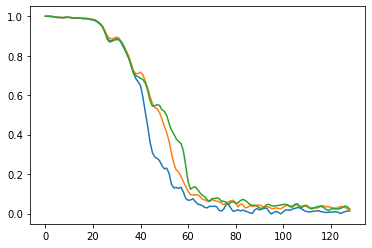

In [34]:
plt.plot( mngr.get_fsc(1) )
plt.plot( mngr.get_fsc(6) )
plt.plot( mngr.get_fsc(12) )

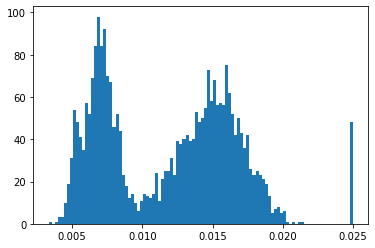

In [38]:
ptcls = mngr.get_ptcls(12)
_ = plt.hist(np.minimum(ptcls.ali_cc[0],0.025),100)

    Volume reconstruction (including half-sets). Box size: 256
    - Input files: prj_005.ptclsraw | tomos_b1.tomostxt
    - Output prefix: prj_005
    - 1 GPU (GPU id: 0), and 1 thread.
    - Bandpass: [0.0 - 127.0]  (roll off: 2.00).
    - Wiener SSNR: S=1.00 F=0.80. Normalized to Mean=0, Std=1.
    - c1 Symmetry. Inversion: Ite=10 Std=0.750000
	Loading data files... Done
    - 2815 Particles (1 classes) in 4 tomograms with max 61 projections.
        Filling fourier space: 100.00%                           
        Reconstructing prj_005_class001_half1.mrc ...  Done.
        Reconstructing prj_005_class001_half2.mrc ...  Done.
        Reconstructing prj_005_class001.mrc ...  Done.


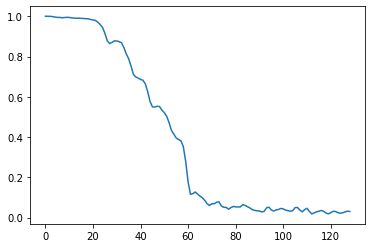

In [47]:
p1 = mngr.get_ptcls(12)
p1.save('prj_005.ptclsraw')

avgr = susan.modules.Averager()
avgr.list_gpus_ids  = [0]
avgr.ctf_correction = 'wiener_ssnr'
avgr.ssnr.S = 1
avgr.ssnr.F = 0.8
avgr.rec_halfsets   = True
avgr.reconstruct('prj_005','tomos_b1.tomostxt','prj_005.ptclsraw',256)

v,a = susan.io.mrc.read('prj_005_class001.mrc')
fsc = susan.utils.fsc_get('prj_005_class001_half1.mrc','prj_005_class001_half2.mrc','mask_b1_01.mrc')
v_f = susan.utils.apply_FOM(v,fsc)
v_f = susan.utils.denoise_l0(v_f,l0_lambda=0.04) # protein occupies 5% of the box
susan.io.mrc.write(v_f,'prj_005_class001_denoised.mrc',a)

refs = susan.data.Reference(n_refs=1)
refs.ref[0] = 'prj_005_class001_denoised.mrc'
refs.msk[0] = 'mask_b1_01.mrc'
refs.save('prj_005.refstxt')

plt.plot(fsc)

In [15]:
# 2D refinements
mngr = susan.project.Manager('prj_005_b1',256)

mngr.initial_reference = 'prj_005.refstxt'
mngr.initial_particles = 'prj_005.ptclsraw'
mngr.tomogram_file     = 'tomos_b1.tomostxt'
mngr.list_gpus_ids     = [0,1,2,3]
mngr.aligner.ctf_correction  = 'cfsc'
mngr.aligner.allow_drift     = True
mngr.averager.ctf_correction = 'wiener'
mngr.cc_threshold   = 0.6
mngr.iteration_type = 2 # 2D refinements

In [16]:
mngr.aligner.bandpass.highpass = 0
mngr.aligner.bandpass.rolloff  = 10

mngr.aligner.refine.levels = 1
mngr.aligner.refine.factor = 2
mngr.aligner.set_offset_search(6)

lp = 40
for i in range(1,11):
    ang_stp = np.rad2deg(np.arctan2(1,lp))
    mngr.aligner.bandpass.lowpass = lp
    mngr.aligner.set_angular_search(4*ang_stp,ang_stp,4*ang_stp,ang_stp)
    bp = mngr.execute_iteration(i)
    lp = min(lp+2,bp)
    m = mngr.get_names_map(i)
    v,a = susan.io.mrc.read(m)
    v_f = susan.utils.apply_FOM(v,mngr.get_fsc(i))
    susan.io.mrc.write(v_f,m[:-4]+'_fom.mrc',a) # save FOM
    v_f = susan.utils.denoise_l0(v_f,l0_lambda=0.03)
    susan.io.mrc.write(v_f,m,a)

Project: prj_005_b1 (Iteration 1)
  [2D Alignment] Start:
  Volume 2D alignment. Box size: 256
    - Input files: tomos_b1.tomostxt | prj_005.refstxt
    - Particles In/Out: prj_005.ptclsraw | prj_005_b1/ite_0001/particles.ptclsraw
    - 4 GPUs (GPU ids: 0,1,2,3), and 4 threads.
    - Bandpass: [0.0 - 40.0]  (roll off: 10.00).
    - On Substack (CFSC). Normalized to Mean=0, Std=1.
    - Angular search: Sym=c1 | Cone=5.728,1.432 | Inplace=5.728,1.432 | Refinement: 1|2.
    - Angles | 100 | 100 [200].
    - Circular offset (2D): [6.00,6.00]. Points: 1469
    - 2815 Particles (1 classes) in 4 tomograms with max 61 projections.
        Aligning particles: 100.00%                              
  [2D Alignment] Finished. Elapsed time: 102.0 seconds (0:01:42.008293).
  [Aligned partices] Processing:
    Class  1:    2815 particles [   1689].
      Half 1:    1418 particles [    851].
      Half 2:    1397 particles [    838].
  [Aligned partices] Done.
  [Reconstruct Maps] Start:
    Volume r

Project: prj_005_b1 (Iteration 5)
  [2D Alignment] Start:
  Volume 2D alignment. Box size: 256
    - Input files: tomos_b1.tomostxt | prj_005_b1/ite_0004/reference.refstxt
    - Particles In/Out: prj_005_b1/ite_0004/particles.ptclsraw | prj_005_b1/ite_0005/particles.ptclsraw
    - 4 GPUs (GPU ids: 0,1,2,3), and 4 threads.
    - Bandpass: [0.0 - 48.0]  (roll off: 10.00).
    - On Substack (CFSC). Normalized to Mean=0, Std=1.
    - Angular search: Sym=c1 | Cone=4.774,1.193 | Inplace=4.774,1.193 | Refinement: 1|2.
    - Angles | 100 | 100 [200].
    - Circular offset (2D): [6.00,6.00]. Points: 1469
    - 2815 Particles (1 classes) in 4 tomograms with max 61 projections.
        Aligning particles: 100.00%                              
  [2D Alignment] Finished. Elapsed time: 103.0 seconds (0:01:43.036650).
  [Aligned partices] Processing:
    Class  1:    2815 particles [   1689].
      Half 1:    1418 particles [    851].
      Half 2:    1397 particles [    838].
  [Aligned partices] Do

Project: prj_005_b1 (Iteration 9)
  [2D Alignment] Start:
  Volume 2D alignment. Box size: 256
    - Input files: tomos_b1.tomostxt | prj_005_b1/ite_0008/reference.refstxt
    - Particles In/Out: prj_005_b1/ite_0008/particles.ptclsraw | prj_005_b1/ite_0009/particles.ptclsraw
    - 4 GPUs (GPU ids: 0,1,2,3), and 4 threads.
    - Bandpass: [0.0 - 56.0]  (roll off: 10.00).
    - On Substack (CFSC). Normalized to Mean=0, Std=1.
    - Angular search: Sym=c1 | Cone=4.092,1.023 | Inplace=4.092,1.023 | Refinement: 1|2.
    - Angles | 100 | 100 [200].
    - Circular offset (2D): [6.00,6.00]. Points: 1469
    - 2815 Particles (1 classes) in 4 tomograms with max 61 projections.
        Aligning particles: 100.00%                              
  [2D Alignment] Finished. Elapsed time: 100.1 seconds (0:01:40.067726).
  [Aligned partices] Processing:
    Class  1:    2815 particles [   1689].
      Half 1:    1418 particles [    851].
      Half 2:    1397 particles [    838].
  [Aligned partices] Do

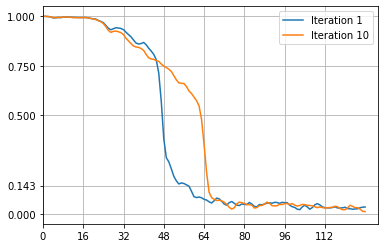

In [17]:
plt.plot( mngr.get_fsc(1),label='Iteration 1' )
plt.plot( mngr.get_fsc(10),label='Iteration 10' )
plt.axis([0,128+5,-0.05,1.05])
plt.yticks([0,0.143,0.5,0.75,1])
plt.xticks(np.arange(0,128,16))
plt.grid(True)
plt.legend()

In [ ]:
_ = napari.view_image(-mngr.get_map(10))

(-0.5, 159.5, 159.5, -0.5)

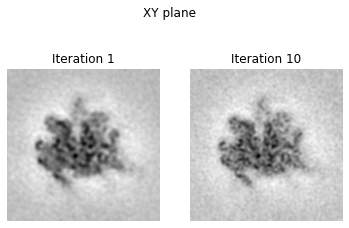

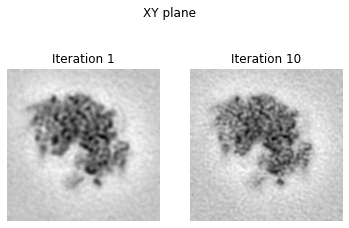

In [43]:
f,ax = plt.subplots(1,2)
f.suptitle('XY plane')
v = susan.read('prj_005_b1/ite_0001/map_class001_fom.mrc')
ax[0].imshow( v[135,208:48:-1,48:208], 'gray' )
ax[0].set_title('Iteration 1')
ax[0].axis('off')
v = susan.read('prj_005_b1/ite_0010/map_class001_fom.mrc')
ax[1].imshow( v[135,208:48:-1,48:208], 'gray' )
ax[1].set_title('Iteration 10')
ax[1].axis('off')
f,ax = plt.subplots(1,2)
f.suptitle('XY plane')
v = susan.read('prj_005_b1/ite_0001/map_class001_fom.mrc')
ax[0].imshow( v[208:48:-1,127,48:208], 'gray' )
ax[0].set_title('Iteration 1')
ax[0].axis('off')
v = susan.read('prj_005_b1/ite_0010/map_class001_fom.mrc')
ax[1].imshow( v[208:48:-1,127,48:208], 'gray' )
ax[1].set_title('Iteration 10')
ax[1].axis('off')